# Pokersters Fantasy Football Notebook
Lets do the data thang

In [1]:
# %pip install sleeper-api-wrapper
# %pip install matplotlib-label-lines

### Initialize

In [56]:
from sleeper_wrapper import League, Stats, Players
import pandas as pd
import numpy as np
import io
import csv
import re
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from labellines import labelLine, labelLines

league_id = 852044618987085824
league = League(league_id)
players = Players()
# players_df = pd.read_pickle('./sleeper_players.pkl')
# ffa_proj_df = pd.read_pickle("./ffa_proj.pkl")
plt.rcParams['figure.figsize'] = [15, 10]

In [103]:
# import player projection data from spreadsheet
projection_file = '2022_projections/2022_week1_9-8-2022_ff_projection.txt'

with open('sleeper_players.pkl', 'wb') as file:
    ffa_proj_df = pd.read_csv(projection_file, sep='\t', index_col=None)
    ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')
    ffa_proj_df['Player_Pos'] = ffa_proj_df['Player'] + ffa_proj_df['Position']
    # why is the abbr for vegas LVR rather than LV??? annoying
    ffa_proj_df['Team'].replace({'LVR': 'LV', 'JAC': 'JAX'}, inplace=True)
    # convert defense player names from common name to abbreviated to match sleeper
    ffa_proj_df.to_pickle('./ffa_proj.pkl')

ffa_proj_df.head()

C:\Users\andre\AppData\Local\Temp/ipykernel_5812/518886910.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')


,Index,a,b,Position,Player,Team,Floor,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
0,1,NaN,NaN,TE,Travis Kelce,KC,13.700000,15.200000,16.600000,1.340000,73.000000,8.750000,0.839000,1,NaN,NaN,Travis KelceTE
1,2,NaN,NaN,RB,Jonathan Taylor,IND,14.400000,19.800000,22.100000,1.700000,75.000000,8.580000,0.219000,1,NaN,NaN,Jonathan TaylorRB
2,3,NaN,NaN,RB,Christian McCaffrey,CAR,15.200000,19.500000,22.900000,2.170000,88.000000,8.360000,1.130000,1,NaN,NaN,Christian McCaffreyRB
3,4,NaN,NaN,WR,Cooper Kupp,LAR,13.500000,18.000000,20.600000,3.150000,96.000000,8.180000,0.853000,1,NaN,NaN,Cooper KuppWR
4,5,NaN,NaN,TE,Mark Andrews,BAL,12.100000,14.400000,16.400000,1.810000,82.000000,7.910000,2.890000,2,NaN,NaN,Mark AndrewsTE


In [104]:
# Import players from sleeper, run this block to get updated players data
players_dict = players.get_all_players()
players_df = pd.DataFrame(players_dict).transpose()
players_df['full_name'] = players_df['full_name'].str.replace('.', '')
players_df['full_name_pos'] = players_df['full_name'] + players_df['position']
players_df = players_df.reset_index()
players_df = players_df.merge(ffa_proj_df, left_on='full_name_pos', right_on='Player_Pos', how='left')
players_df['player_id'] = players_df['index'].fillna(players_df['Team'])
players_df = players_df.set_index('player_id')
players_df = players_df.drop(columns=['index'])
for i in players_df.loc[players_df['fantasy_positions'].apply(lambda x: True if x and 'DEF' in x else False).tolist()].index.tolist():
    dst_matches = ffa_proj_df[(ffa_proj_df['Position'] == 'DST') & (ffa_proj_df['Team'] == i)]
    if not dst_matches.empty:
        players_df.loc[i, ffa_proj_df.columns] = dst_matches.iloc[0]
players_df[ffa_proj_df.columns] = players_df[ffa_proj_df.columns].fillna(0)
players_df.to_pickle('./sleeper_players.pkl')
players_df.head()

C:\Users\andre\AppData\Local\Temp/ipykernel_5812/1579613147.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  players_df['full_name'] = players_df['full_name'].str.replace('.', '')


,pandascore_id,rotowire_id,search_full_name,swish_id,practice_description,first_name,metadata,birth_country,hashtag,depth_chart_position,...,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
player_id,,,,,,,,,,,,,,,,,,,,,
2103,None,9866,codybooth,None,None,Cody,None,None,#codybooth-NFL-FA-60,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6250,None,None,eurndrausbryant,None,None,Eurndraus,None,None,#eurndrausbryant-NFL-FA-0,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4116,None,11794,antoniogarcia,None,None,Antonio,None,None,#antoniogarcia-NFL-FA-0,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
8465,None,16062,spencerburford,1123542,None,Spencer,None,None,#spencerburford-NFL-SF-74,RG,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6177,None,13746,khalensaunders,831799,None,Khalen,None,None,#khalensaunders-NFL-KC-99,LDT,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [105]:
ffa_proj_df.head()

,Index,a,b,Position,Player,Team,Floor,Points,Ceiling,SD,Uncertainty,VOR,Drop Off,Tier,ADP,AAV,Player_Pos
0,1,NaN,NaN,TE,Travis Kelce,KC,13.700000,15.200000,16.600000,1.340000,73.000000,8.750000,0.839000,1,NaN,NaN,Travis KelceTE
1,2,NaN,NaN,RB,Jonathan Taylor,IND,14.400000,19.800000,22.100000,1.700000,75.000000,8.580000,0.219000,1,NaN,NaN,Jonathan TaylorRB
2,3,NaN,NaN,RB,Christian McCaffrey,CAR,15.200000,19.500000,22.900000,2.170000,88.000000,8.360000,1.130000,1,NaN,NaN,Christian McCaffreyRB
3,4,NaN,NaN,WR,Cooper Kupp,LAR,13.500000,18.000000,20.600000,3.150000,96.000000,8.180000,0.853000,1,NaN,NaN,Cooper KuppWR
4,5,NaN,NaN,TE,Mark Andrews,BAL,12.100000,14.400000,16.400000,1.810000,82.000000,7.910000,2.890000,2,NaN,NaN,Mark AndrewsTE


### Get Leaguemates data

In [106]:
users = league.get_users()
users_df = pd.DataFrame(users)
users_df = users_df.set_index(users_df.columns[0])
users_df

,settings,metadata,league_id,is_owner,is_bot,display_name,avatar
user_id,,,,,,,
375038190341611520,None,"{'team_name': 'The Trolley Problems', 'mention...",852044618987085824,False,False,thinkfast86,3c7def417a4613d104ae66403af0e0e7
607043401484926976,None,"{'mascot_item_type_id_leg_6': 'tony-montana', ...",852044618987085824,False,False,mmasison,e36c64e702e2db846c91eb439a13df6a
608864437348163584,None,"{'mascot_item_type_id_leg_6': 'pizza', 'mascot...",852044618987085824,False,False,TheVermanator,None
723630209273765888,None,"{'team_name': 'Pacheco's Player Picture', 'men...",852044618987085824,True,False,benslayer68,None
723633476015857664,None,"{'team_name': 'Waiting For 2023', 'mention_pn'...",852044618987085824,False,False,dlaffs,6e0dc0a80e7d0560d8ef4777d3a90b16
723650381690769408,None,"{'mascot_item_type_id_leg_6': 'ref', 'mascot_m...",852044618987085824,False,False,mikulis,ea2334c4e55f4c7d1d1544544eae3f54
723683736822059008,None,"{'mascot_item_type_id_leg_6': 'dogecoin', 'mas...",852044618987085824,True,False,schlaich,0008e9a0c13d1ebb16549afa8e884ef3
723753245457104896,None,"{'team_name': 'Hop on the Magic Gus Bus', 'men...",852044618987085824,False,False,izzyfoshizzy8,15d7cf259bc30eab8f6120f45f652fb6
723755503108349952,None,"{'mascot_item_type_id_leg_6': 'taco', 'mascot_...",852044618987085824,False,False,hunterm19,505a21249447d6533b5e1fc3dd53d755


In [107]:
rosters = league.get_rosters()
rosters_df = pd.DataFrame(rosters)
# if someone doesn't have a team name, use username
rosters_df['team_name'] = rosters_df['owner_id'].apply(lambda x: users_df.loc[x]['metadata']['team_name'] if 'team_name' in users_df.loc[x]['metadata'] else users_df.loc[x]['display_name'])

def get_bench(row):
    return [x for x in row['players'] if x not in row['starters']]

rosters_df['bench'] = rosters_df.apply(get_bench, axis=1)
rosters_df.head()

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,keepers,co_owners,team_name,bench
0,None,"[7610, 6130, 7608, 4068, 4037, 6126, 7606, 704...","{'wins': 0, 'waiver_position': 3, 'waiver_budg...",1,[8154],"[4037, 4068, 5917, 6126, 6130, 7042, 7591, 760...",None,723630209273765888,"{'streak': '2L', 'record': 'WWWWWLLLWWWWLWWWLW...",852044618987085824,[4068],None,Pacheco's Player Picture,"[5917, 7591, 7670, 8132, 8154, 8167, 8205]"
1,None,"[6904, 4098, 7607, 4039, 5872, 4217, 5045, 49,...","{'wins': 0, 'waiver_position': 4, 'waiver_budg...",2,None,"[3202, 4039, 4098, 4217, 49, 5045, 5872, 5987,...",None,375038190341611520,"{'streak': '4W', 'record': 'WWWLWWWLWLWWWWLLWW...",852044618987085824,"[4039, 5872]",None,The Trolley Problems,"[3202, 5987, 6805, 8121, 8144, 8153]"
2,None,"[4984, 3198, 4199, 2133, 1479, 5844, 5937, 608...","{'wins': 0, 'waiver_position': 11, 'waiver_bud...",3,None,"[1352, 1479, 1825, 2133, 2309, 2319, 3198, 419...",None,607043401484926976,"{'streak': '1L', 'record': 'WWLWLLLLWWLLLLLLWL...",852044618987085824,"[4984, 6806]",None,💩 King Henry,"[1352, 1825, 2309, 2319, 6806, 6828, 947]"
3,None,"[2028, 6938, 6820, 3321, 2197, 5001, 2374, 391...","{'wins': 0, 'waiver_position': 10, 'waiver_bud...",4,None,"[2028, 2197, 2374, 3225, 3321, 3664, 391, 4149...",None,723633476015857664,"{'streak': '1W', 'record': 'LLWLWWWWLWLLWWLLLL...",852044618987085824,[2197],None,Waiting For 2023,"[3225, 3664, 4149, 4951, 5086, 7567]"
4,None,"[6797, 5892, 1535, 2449, 4950, 1466, 7611, 466...","{'wins': 0, 'waiver_position': 1, 'waiver_budg...",5,None,"[1466, 1535, 2449, 3214, 4666, 4950, 5347, 589...",None,608864437348163584,"{'streak': '4L', 'restrict_pn_scoring_starters...",852044618987085824,[6797],None,Kneel Before the 👑,"[3214, 5347, 5947, 6955, 7527, 8135]"


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)


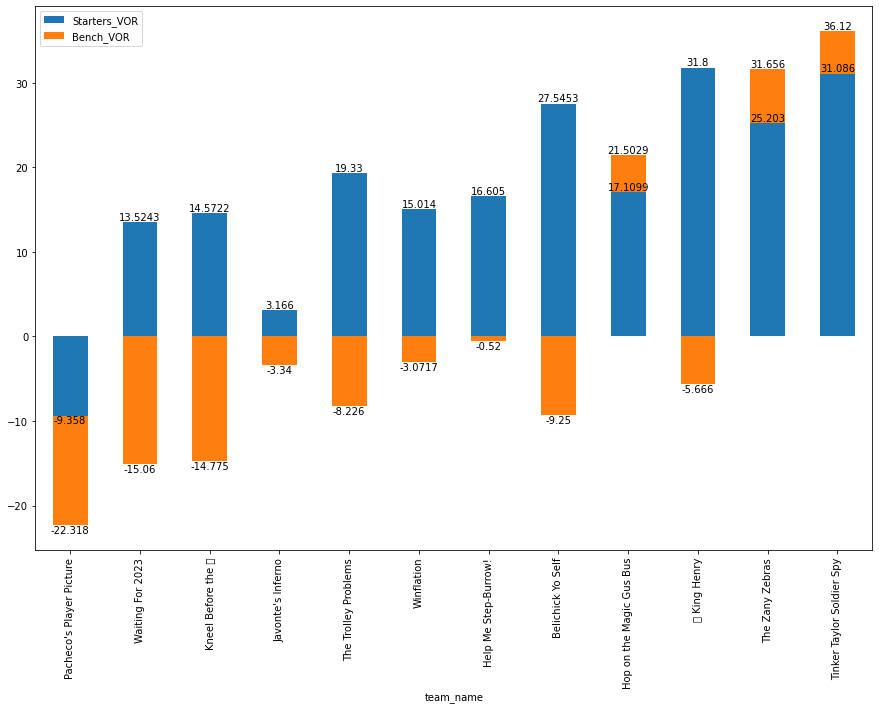

In [108]:
#  Post-draft VOR calculation
rosters_df['Starters_VOR'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))
rosters_df['Bench_VOR'] = rosters_df['bench'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))
rosters_df['Team_VOR'] = rosters_df['players'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['VOR']))

ax = rosters_df.sort_values('Team_VOR')[['Starters_VOR', 'Bench_VOR', 'team_name']].plot.bar(x='team_name', stacked=True)
for container in ax.containers:
    ax.bar_label(container)

[Text(0, 0, '-9.358'),
 Text(0, 0, '3.166'),
 Text(0, 0, '13.5243'),
 Text(0, 0, '14.5722'),
 Text(0, 0, '15.014'),
 Text(0, 0, '16.605'),
 Text(0, 0, '17.1099'),
 Text(0, 0, '19.33'),
 Text(0, 0, '25.203'),
 Text(0, 0, '27.5453'),
 Text(0, 0, '31.086'),
 Text(0, 0, '31.8')]

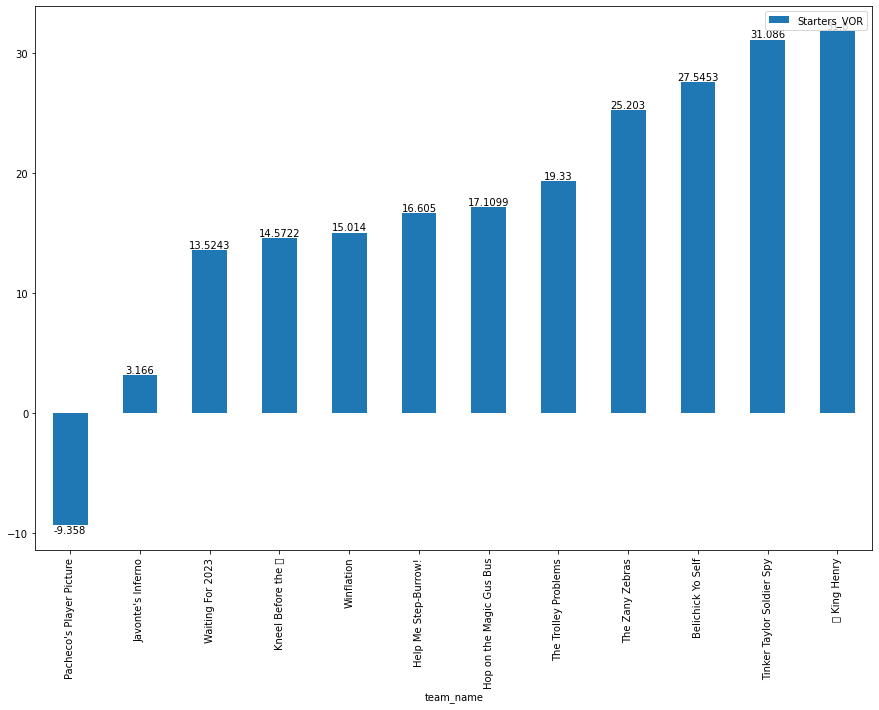

In [109]:
ax = rosters_df.sort_values('Starters_VOR').plot.bar(x='team_name', y='Starters_VOR')
ax.bar_label(ax.containers[0])


In [110]:
for col in ['Floor','Points','Ceiling','Uncertainty']:
    rosters_df['Starters_' + col] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']][col]))

rosters_df['Starters_Variance'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['SD']**2))
rosters_df['Starters_SD'] = rosters_df['Starters_Variance']**(1/2)

In [111]:
players_df.loc[[x for x in rosters_df.iloc[4]['starters'] if x != '0']].loc[:, ['full_name', 'Points', 'SD']]

,full_name,Points,SD
player_id,,,
6797,Justin Herbert,21.700000,0.817000
5892,David Montgomery,12.400000,2.070000
1535,Cordarrelle Patterson,11.300000,1.970000
2449,Stefon Diggs,14.700000,1.320000
4950,Christian Kirk,9.850000,1.870000
1466,Travis Kelce,15.200000,1.340000
7611,Rhamondre Stevenson,9.270000,1.020000
4666,Younghoe Koo,0.000000,0.000000
BAL,NaN,4.540000,0.494000


[Text(0, 0, '67.32'),
 Text(0, 0, '77.81'),
 Text(0, 0, '96.59'),
 Text(0, 0, '98.13'),
 Text(0, 0, '98.96'),
 Text(0, 0, '99.84'),
 Text(0, 0, '101.49'),
 Text(0, 0, '102.47'),
 Text(0, 0, '109.51'),
 Text(0, 0, '109.64'),
 Text(0, 0, '110.61'),
 Text(0, 0, '115.71')]

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)


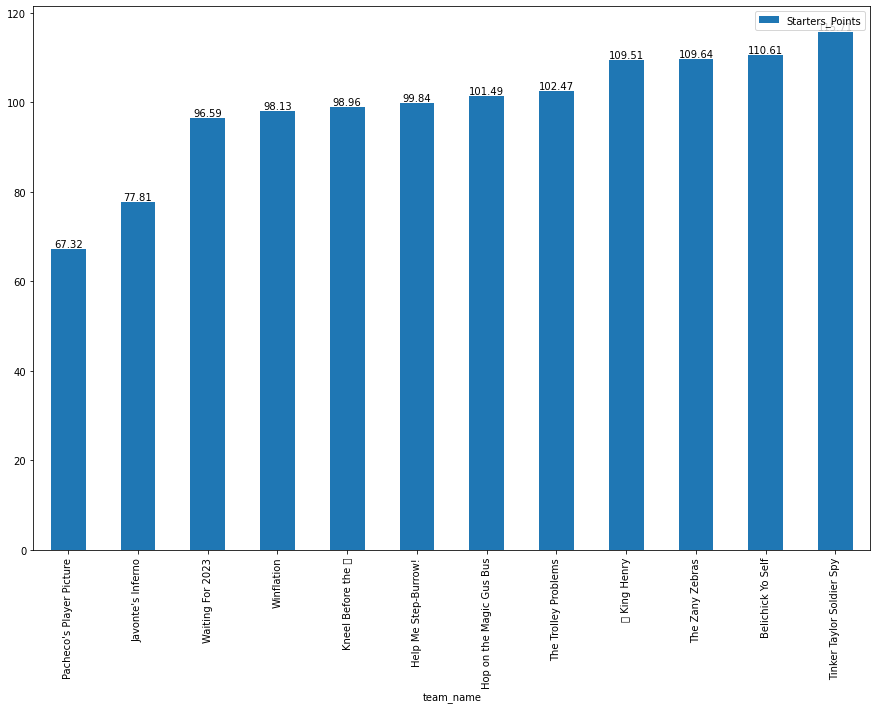

In [112]:
ax = rosters_df.sort_values('Starters_Points').plot.bar(x='team_name', y='Starters_Points')
ax.bar_label(ax.containers[0])


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128169 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128081 missing from current font.
  font.set_text(s, 0, flags=flags)


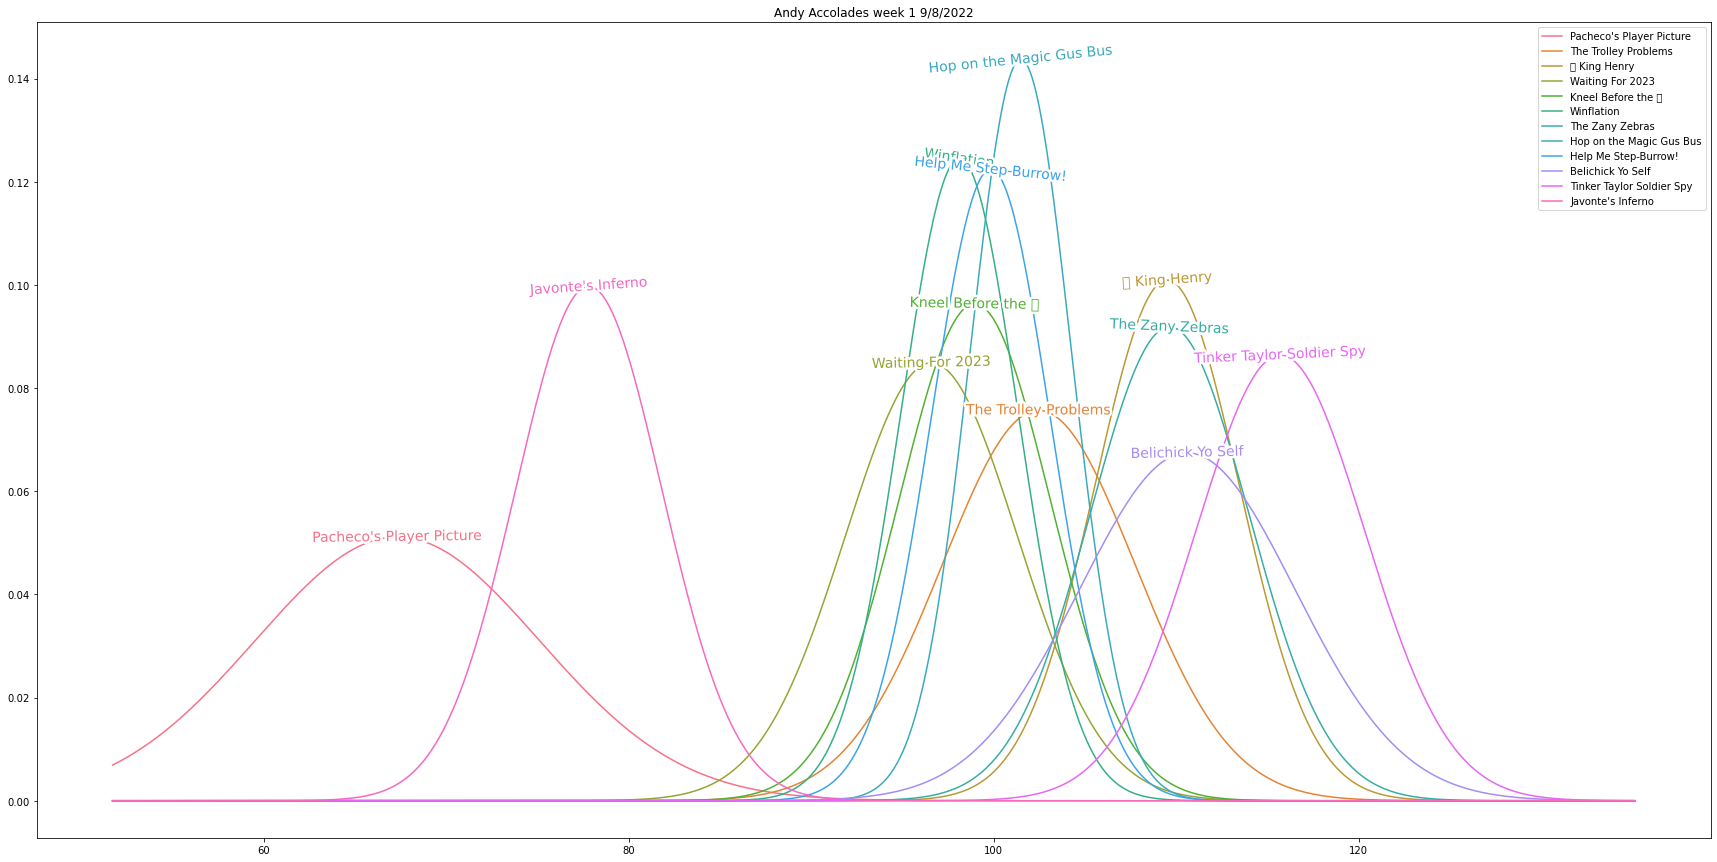

In [113]:
plt.rcParams['figure.figsize'] = [30, 15]
fig, ax1 = plt.subplots()
colors = sns.color_palette("husl", rosters_df.shape[0])
ax1.set_prop_cycle('color', colors)
x_axis = np.arange(rosters_df['Starters_Points'].min() - 2*rosters_df['Starters_SD'].max(), rosters_df['Starters_Points'].max() + 2.5*rosters_df['Starters_SD'].max(), .1)

for roster in rosters_df.iterrows():  
    plt.plot(x_axis, norm.pdf(x_axis, roster[1]['Starters_Points'], roster[1]['Starters_SD']), label=roster[1]['team_name'])
    
labelLines(plt.gca().get_lines(), fontsize=14, align=True,  xvals = rosters_df['Starters_Points'], zorder=2.5)
plt.legend()

ax1.title.set_text('Andy Accolades week 1 9/8/2022')
plt.show()

In [114]:
rosters_df.loc[:, ['team_name', 'Starters_Points', 'Starters_SD']].sort_values(by='Starters_Points')

,team_name,Starters_Points,Starters_SD
0,Pacheco's Player Picture,67.320000,7.799511
11,Javonte's Inferno,77.810000,4.000324
3,Waiting For 2023,96.590000,4.699334
5,Winflation,98.130000,3.203574
4,Kneel Before the 👑,98.960000,4.141573
8,Help Me Step-Burrow!,99.840000,3.259052
7,Hop on the Magic Gus Bus,101.490000,2.775745
1,The Trolley Problems,102.470000,5.270916
2,💩 King Henry,109.510000,3.952242
6,The Zany Zebras,109.640000,4.341985


In [115]:
rosters_df.loc[:, ['team_name', 'Starters_Ceiling', 'Starters_Floor']].sort_values(by='Starters_Ceiling')

,team_name,Starters_Ceiling,Starters_Floor
0,Pacheco's Player Picture,89.440000,40.990000
11,Javonte's Inferno,98.740000,59.900000
5,Winflation,109.970000,85.300000
3,Waiting For 2023,115.580000,79.720000
8,Help Me Step-Burrow!,118.670000,79.370000
4,Kneel Before the 👑,119.260000,81.310000
7,Hop on the Magic Gus Bus,120.380000,89.750000
2,💩 King Henry,126.100000,97.350000
1,The Trolley Problems,130.470000,79.910000
9,Belichick Yo Self,133.070000,93.790000


In [116]:
week = 1
matchups = league.get_matchups(week)
matchups_df = pd.DataFrame(matchups)
mu = matchups_df.groupby('matchup_id')

In [117]:
num_matchups = len(rosters_df) // 2

matchup_prob_df = pd.DataFrame()


pd.set_option('display.float_format', '{:.6f}'.format)

for i in range(1, num_matchups+1):
    p1, p2 = mu.get_group(i)['roster_id'].iloc[0] - 1, mu.get_group(i)['roster_id'].iloc[1] - 1
    d_mean = rosters_df.iloc[p1]['Starters_Points'] - rosters_df.iloc[p2]['Starters_Points']
    d_var = rosters_df.iloc[p1]['Starters_Variance'] + rosters_df.iloc[p2]['Starters_Variance']
    # victory_prob = (1 - norm(d_mean, d_var**(1/2)).cdf(0))
    victory_prob = (1 - norm(d_mean, d_var).cdf(0))
    row = {'team1': rosters_df.iloc[p1]['team_name'], 'team2': rosters_df.iloc[p2]['team_name'], 'victory_probability': victory_prob, 'd_mean': d_mean, 'd_var': d_var}
    matchup_prob_df = matchup_prob_df.append(row, ignore_index=True)

print(matchup_prob_df.loc[:, ['team1', 'team2', 'victory_probability']])

                      team1                      team2  victory_probability
0  Pacheco's Player Picture  Tinker Taylor Soldier Spy             0.277905
1           The Zany Zebras       Help Me Step-Burrow!             0.630242
2          Waiting For 2023          Belichick Yo Self             0.402968
3              💩 King Henry   Hop on the Magic Gus Bus             0.634516
4                Winflation          Javonte's Inferno             0.780428
5      The Trolley Problems         Kneel Before the 👑             0.531131


In [72]:
players_df[players_df['Position'] == 'DST']['VOR'].sort_values()

player_id
ATL   -20.200000
NYJ   -19.100000
JAX   -14.700000
SEA   -14.400000
LV    -14.400000
DET   -13.500000
HOU   -12.100000
NYG   -10.900000
CAR    -9.020000
ARI    -7.480000
KC     -7.400000
WAS    -6.240000
BAL    -5.750000
PHI    -5.450000
DEN    -5.190000
CHI    -5.130000
IND    -4.650000
CIN    -4.570000
TEN    -3.910000
CLE    -1.670000
NE     -1.460000
LAC    -1.000000
SF      0.000000
MIN     0.790000
NO      1.620000
MIA     3.160000
TB      3.330000
GB      4.660000
DAL     5.350000
PIT     5.460000
BUF     5.910000
LAR     5.950000
Name: VOR, dtype: float64